# Bachelor Thesis
## MNIST classification using persistent homology

### Installs/Imports

In [2]:
#!pip install giotto-tda
#!pip install catboost
#!pip install lightgbm
#!pip install xgboost

distutils: /home/snopoff/miniconda3/envs/topology/include/python3.9/UNKNOWN
sysconfig: /home/snopoff/miniconda3/envs/topology/include/python3.9
user = False
home = None
root = None
prefix = None
     |████▏                           | 9.0 MB 5.3 MB/s eta 0:00:12^C             | 1.9 MB 1.6 MB/s eta 0:00:42

ERROR: Operation cancelled by user
distutils: /home/snopoff/miniconda3/envs/topology/include/python3.9/UNKNOWN
sysconfig: /home/snopoff/miniconda3/envs/topology/include/python3.9
user = False
home = None
root = None
prefix = None
     |████████████████████████████████| 2.0 MB 1.5 MB/s eta 0:00:01
^C
ERROR: Operation cancelled by user
distutils: /home/snopoff/miniconda3/envs/topology/include/python3.9/UNKNOWN
sysconfig: /home/snopoff/miniconda3/envs/topology/include/python3.9
user = False
home = None
root = None
prefix = None
     |▍                               | 2.1 MB 1.5 MB/s eta 0:01:52^C

ERROR: Operation cancelled by user


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import plotly as pl
from plotly.subplots import make_subplots
from sklearn import datasets
from IPython.display import HTML

from sklearn.model_selection import train_test_split

from gtda.homology import CubicalPersistence
from gtda.images import Binarizer, RadialFiltration, DensityFiltration
from gtda.diagrams import Scaler

from gtda.diagrams import HeatKernel

from sklearn.pipeline import make_pipeline, make_union, Pipeline
from gtda.diagrams import PersistenceEntropy, Amplitude
from gtda.images import HeightFiltration
from sklearn import set_config

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

from sklearn.model_selection import GridSearchCV
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

from scipy.stats import pearsonr

### 1. Load MNIST Data and create train/test datasets

Let's load MNIST data

In [4]:
from sklearn.datasets import fetch_openml

X, y = fetch_openml("mnist_784", version=1, return_X_y=True)

In [5]:
y = y.to_numpy()
X = X.to_numpy().reshape((-1, 28, 28))

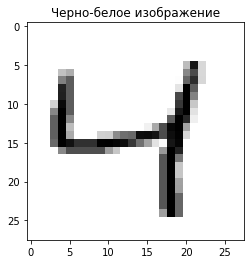

In [ ]:
plt.imshow(X[2], cmap='gray_r')
plt.title("Черно-белое изображение")
plt.show()

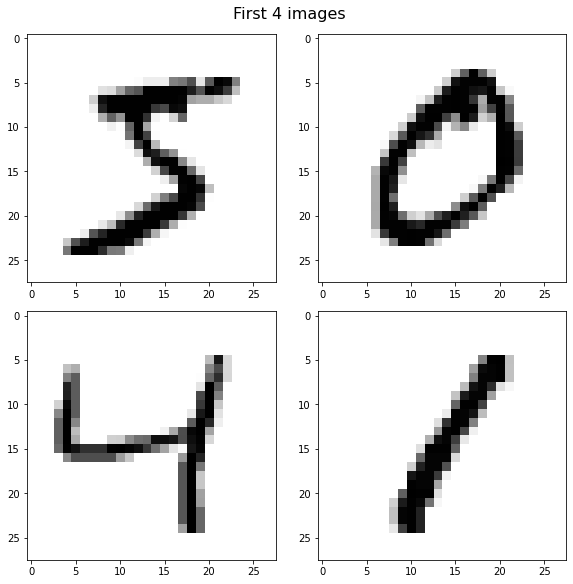

In [ ]:
fig, axes = plt.subplots(2, 2, figsize = (8, 8), constrained_layout=True)
for i in range(4):
    ax = axes.flat[i]
    ax.imshow(X[i], cmap='gray_r')
fig.suptitle("First 4 images", fontsize = 16)
plt.show()

In [10]:
train_size, test_size = 700, 300


X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=train_size, test_size=test_size, random_state = 21, shuffle = True)

In [7]:
y_train.shape

(700,)

### 2. Create cubical complexes from data and extract topological features

#### 2.1 Binarization

In [ ]:
binarizer = Binarizer(threshold=0.4)

In [ ]:
X_bin = binarizer.fit_transform(X).reshape((-1, 28, 28))

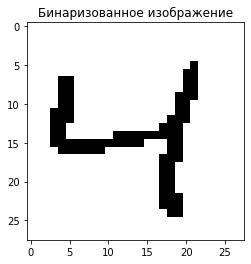

In [ ]:
plt.imshow(X_bin[2], cmap='gray_r')
plt.title("Бинаризованное изображение")
plt.show()

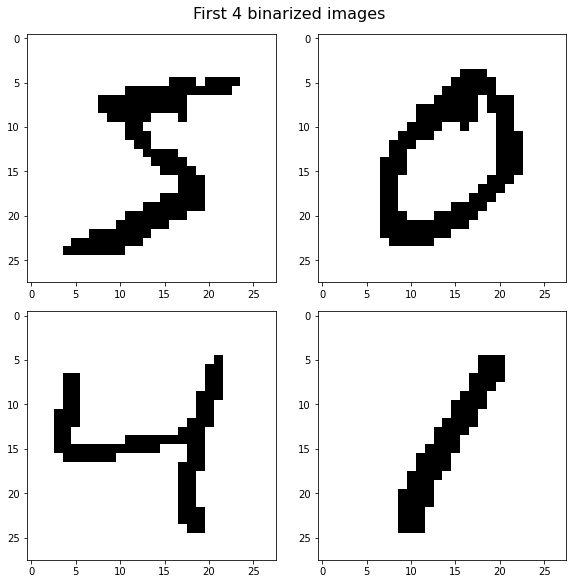

In [ ]:
fig, axes = plt.subplots(2, 2, figsize = (8, 8), constrained_layout=True)
for i in range(4):
    ax = axes.flat[i]
    ax.imshow(X_bin[i], cmap = 'gray_r')
fig.suptitle("First 4 binarized images", fontsize = 16)
plt.show()

#### 2.2 Filtration

In [ ]:
radial_filtration = RadialFiltration(center=np.array([20, 6]))
height_filtration = HeightFiltration(direction=np.array([1,0]))
density_filtration = DensityFiltration(radius=5)

rad = radial_filtration.fit_transform(X_bin).reshape((-1, 28, 28))
height = height_filtration.fit_transform(X_bin).reshape((-1, 28, 28))
dens = density_filtration.fit_transform(X_bin).reshape((-1, 28, 28))
img = X[2]

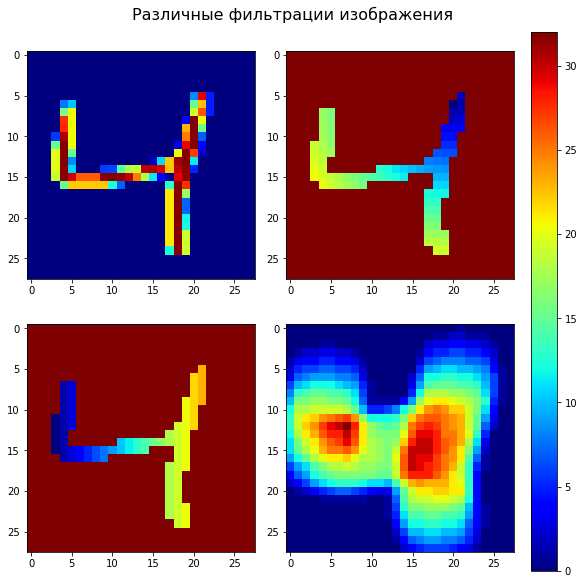

In [ ]:
fig, axes = plt.subplots(2, 2, figsize = (8, 8), constrained_layout=True)
axes[0][0].imshow(img, cmap='jet')
axes[0][1].imshow(rad[2], cmap='jet')
axes[1][0].imshow(height[2], cmap='jet')
im = axes[1][1].imshow(dens[2], cmap='jet')

fig.suptitle("Различные фильтрации изображения", fontsize = 16)
fig.colorbar(im, ax=axes.ravel().tolist())
plt.show()

In [ ]:
X_filt = radial_filtration.fit_transform(X_bin).reshape((-1, 28, 28))

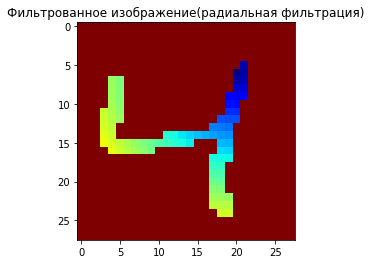

In [ ]:
plt.imshow(X_filt[2], cmap='jet')
plt.title("Фильтрованное изображение(радиальная фильтрация)")
plt.show()

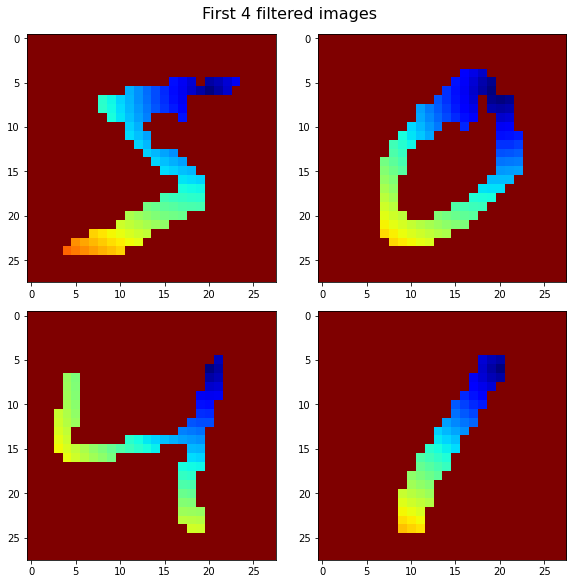

In [ ]:
fig, axes = plt.subplots(2, 2, figsize = (8, 8), constrained_layout=True)
for i in range(4):
    ax = axes.flat[i]
    ax.imshow(X_filt[i], cmap = "jet")
fig.suptitle("First 4 filtered images", fontsize = 16)
plt.show()

#### 2.3 Persistence

In [ ]:
cubical_persistence = CubicalPersistence(n_jobs=-1)

In [ ]:
X_rad = cubical_persistence.fit_transform(rad)
X_height = cubical_persistence.fit_transform(height)
X_dens = cubical_persistence.fit_transform(dens)

In [ ]:
cubical_persistence.plot(X_rad)

In [ ]:
cubical_persistence.plot(X_height)

In [ ]:
cubical_persistence.plot(X_dens)

In [ ]:
X_pers = cubical_persistence.fit_transform(X_filt)

In [ ]:
cubical_persistence.plot(X_pers[2][None, :, :])

#### 2.4 Scaling

In [ ]:
scaler = Scaler()

In [ ]:
X_rad_scale = scaler.fit_transform(X_rad)
X_height_scale = scaler.fit_transform(X_height)
X_dens_scale = scaler.fit_transform(X_dens)

In [ ]:
scaler.plot(X_height_scale)

In [ ]:
scaler.plot(X_rad_scale)

In [ ]:
scaler.plot(X_dens_scale)

In [ ]:
X_scale = scaler.fit_transform(X_pers)

In [ ]:
scaler.plot(X_scale[0][None, :, :])

### 3. Vector representation

In [ ]:
heat = HeatKernel(sigma=.15, n_bins=60, n_jobs=-1)

In [ ]:
X_heat = heat.fit_transform(X_scale)

In [ ]:
heat.fit_transform_plot(X_rad_scale,colorscale='jet')

array([[[[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         ...,
         [ 7.34794600e-05,  7.73586555e-05,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 1.83242486e-05,  0.00000000e+00, -7.73586555e-05, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00, -1.83242486e-05, -7.34794600e-05, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00]],

        [[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e

In [ ]:
heat.fit_transform_plot(X_dens_scale,colorscale='jet')

array([[[[ 0.        ,  0.        ,  0.        , ...,  0.        ,
           0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.        , ...,  0.        ,
           0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.        , ...,  0.        ,
           0.        ,  0.        ],
         ...,
         [ 0.97530156,  0.48757006,  0.        , ...,  0.        ,
           0.        ,  0.        ],
         [ 0.50564106,  0.        , -0.48757006, ...,  0.        ,
           0.        ,  0.        ],
         [ 0.        , -0.50564106, -0.97530156, ...,  0.        ,
           0.        ,  0.        ]],

        [[ 0.        ,  0.        ,  0.        , ...,  0.        ,
           0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.        , ...,  0.        ,
           0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.        , ...,  0.        ,
           0.        ,  0.        ],
         ...,
         [ 0.        ,  0.        

In [ ]:
heat.fit_transform_plot(X_height_scale, colorscale='jet')

array([[[[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]]]])

In [ ]:
heat.plot(X_heat[2][None, :, :], homology_dimension_idx=0, colorscale='jet')

### 4. Creating pipeline

In [8]:
direction_list = [[1, 0], [1, 1], [0, 1], [-1, 1], [-1, 0], [-1, -1], [0, -1], [1, -1]]

center_list = [
    [13, 6],
    [6, 13],
    [13, 13],
    [20, 13],
    [13, 20],
    [6, 6],
    [6, 20],
    [20, 6],
    [20, 20],
]

radius_list = [2, 4, 6]

# Creating a list of all filtration transformer, we will be applying
filtration_list = (
    [
        HeightFiltration(direction=np.array(direction), n_jobs=-1)
        for direction in direction_list
    ]
    + [RadialFiltration(center=np.array(center), n_jobs=-1) for center in center_list]
    + [DensityFiltration(radius=r) for r in radius_list]
)

# Creating the diagram generation pipeline
diagram_steps = [
    [
        Binarizer(threshold=0.4, n_jobs=-1),
        filtration,
        CubicalPersistence(n_jobs=-1),
        Scaler(n_jobs=-1),
    ]
    for filtration in filtration_list
]

# Listing all metrics we want to use to extract diagram amplitudes
metric_list = [
    {"metric": "bottleneck", "metric_params": {}},
    {"metric": "wasserstein", "metric_params": {"p": 1}},
    {"metric": "wasserstein", "metric_params": {"p": 2}},
    {"metric": "landscape", "metric_params": {"p": 1, "n_layers": 1, "n_bins": 100}},
    {"metric": "landscape", "metric_params": {"p": 1, "n_layers": 2, "n_bins": 100}},
    {"metric": "landscape", "metric_params": {"p": 2, "n_layers": 1, "n_bins": 100}},
    {"metric": "landscape", "metric_params": {"p": 2, "n_layers": 2, "n_bins": 100}},
    {"metric": "betti", "metric_params": {"p": 1, "n_bins": 100}},
    {"metric": "betti", "metric_params": {"p": 2, "n_bins": 100}},
    {"metric": "heat", "metric_params": {"p": 1, "sigma": 1.6, "n_bins": 100}},
    {"metric": "heat", "metric_params": {"p": 1, "sigma": 3.2, "n_bins": 100}},
    {"metric": "heat", "metric_params": {"p": 2, "sigma": 1.6, "n_bins": 100}},
    {"metric": "heat", "metric_params": {"p": 2, "sigma": 3.2, "n_bins": 100}},
]


feature_union = make_union(
    *[PersistenceEntropy(nan_fill_value=-1)] #add features
    + [Amplitude(**metric, n_jobs=-1) for metric in metric_list]
)

tda_union = make_union(
    *[make_pipeline(*diagram_step, feature_union) for diagram_step in diagram_steps],
    n_jobs=-1
)

set_config(display='diagram')

tda_union

FeatureUnion(n_jobs=-1,
             transformer_list=[('pipeline-1',
                                Pipeline(steps=[('binarizer',
                                                 Binarizer(n_jobs=-1,
                                                           threshold=0.4)),
                                                ('heightfiltration',
                                                 HeightFiltration(direction=array([1, 0]),
                                                                  n_jobs=-1)),
                                                ('cubicalpersistence',
                                                 CubicalPersistence(n_jobs=-1)),
                                                ('scaler', Scaler(n_jobs=-1)),
                                                ('featureunion',
                                                 FeatureUnion(transformer_list=[('persistenceentropy',
                                                                                 Persist...
                                                                                           metric_params={'n_bins': 100,
                                                                                                          'p': 1,
                                                                                                          'sigma': 1.6},
                                                                                           n_jobs=-1)),
                                                                                ('amplitude-11',
                                                                                 Amplitude(metric='heat',
                                                                                           metric_params={'n_bins': 100,
                                                                                                          'p': 1,
                                                                                                          'sigma': 3.2},
                                                                                           n_jobs=-1)),
                                                                                ('amplitude-12',
                                                                                 Amplitude(metric='heat',
                                                                                           metric_params={'n_bins': 100,
                                                                                                          'p': 2,
                                                                                                          'sigma': 1.6},
                                                                                           n_jobs=-1)),
                                                                                ('amplitude-13',
                                                                                 Amplitude(metric='heat',
                                                                                           metric_params={'n_bins': 100,
                                                                                                          'p': 2,
                                                                                                          'sigma': 3.2},
                                                                                           n_jobs=-1))]))]))])

In [11]:
X_train_tda = tda_union.fit_transform(X_train)
X_test_tda = tda_union.transform(X_test)
X_train_tda.shape

(700, 560)

### 5. Classification

Random Forest Classifier:

In [ ]:
rf = RandomForestClassifier()
rf.fit(X_train_tda, y_train)

acc_rf = rf.score(X_train_tda, y_train)
score_rf = rf.score(X_test_tda, y_test)

Logistic Regression:

In [ ]:
lr = LogisticRegression()
lr.fit(X_train_tda, y_train)

acc_lr = lr.score(X_train_tda, y_train)
score_lr = lr.score(X_test_tda, y_test)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Support Vector Machine Classifier:

In [ ]:
svc = SVC(kernel='linear')
svc.fit(X_train_tda, y_train)

acc_svc = svc.score(X_train_tda, y_train)
score_svc = svc.score(X_test_tda, y_test)

In [ ]:
svc.get_params()

{'C': 1.0,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'scale',
 'kernel': 'linear',
 'max_iter': -1,
 'probability': False,
 'random_state': None,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

LightGBM

In [ ]:
lgbm = LGBMClassifier()
lgbm.fit(X_train_tda, y_train)

acc_lgbm = lgbm.score(X_train_tda, y_train)
score_lgbm = lgbm.score(X_test_tda, y_test)

CatBoost

In [ ]:
cat = CatBoostClassifier()#task_type="GPU", devices='0:1')
cat.fit(X_train_tda, y_train, verbose=False)

acc_cat = cat.score(X_train_tda, y_train)
score_cat = cat.score(X_test_tda, y_test)

XGBoost

In [ ]:
xgb = XGBClassifier()
xgb.fit(X_train_tda, y_train)

acc_xgb = xgb.score(X_train_tda, y_train)
score_xgb = xgb.score(X_test_tda, y_test)

In [ ]:
print("RF:\t", acc_rf, "\t", score_rf)
print("LR:\t", acc_lr, "\t", score_lr)
print("SVC:\t", acc_svc, "\t", score_svc)
print("LGBM:\t", acc_lgbm, "\t", score_lgbm)
print("CatBoost:", acc_cat, "\t", score_cat)
print("xgb:\t", acc_xgb, "\t", score_xgb)

RF:	 1.0 	 0.89
LR:	 0.9885714285714285 	 0.9033333333333333
SVC:	 1.0 	 0.8933333333333333
LGBM:	 1.0 	 0.9
CatBoost: 1.0 	 0.8933333333333333
xgb:	 1.0 	 0.8833333333333333


### 6. Tuning

#### 6.1 Feature Selection

In [ ]:
rf = RandomForestClassifier()
rf.fit(X_train_tda, y_train)

print(rf.score(X_test_tda, y_test))

len(rf.feature_importances_)
#bestFeatures = rf.feature_importances_.argsort()[-250:][::-1]
#X_train_best = X_train_tda[:, bestFeatures]

0.89


644

In [ ]:
bestFeatures = rf.feature_importances_.argsort()[-200:][::-1]
X_train_best = X_train_tda[:, bestFeatures]
X_test_best = X_test_tda[:, bestFeatures]

#### 6.2 Tuning models

##### 6.2.1 Random Forest __(0.8842913563943607 for 200 features & 0.8742831639827348 for 250)__

In [53]:
# rf_params = {
#     "n_estimators": [500, 1000, 2000],
#     'max_depth': [80, 90, 100],
#     'max_features': [2, 3, 4],
#     'min_samples_leaf': [3, 4, 5],
#     'min_samples_split': [8, 10, 12],
#     'n_estimators': [100, 200, 300, 1000]
# }

# rf = RandomForestClassifier(random_state=42)

# rf_grid = GridSearchCV(
#     estimator=rf, param_grid=rf_params, cv=3, n_jobs=-1, verbose=4
# )

# rf_grid.fit(X_train_tda, y_train)
rf_best = {'max_depth': 80,
 'max_features': 4,
 'min_samples_leaf': 3,
 'min_samples_split': 8,
 'n_estimators': 200};

rf = RandomForestClassifier(random_state=42, **rf_best)
rf.fit(X_train_tda, y_train)
rf_bestacc = rf.score(X_train_tda, y_train)
rf_bestscore = rf.score(X_test_tda, y_test)

##### 6.2.2 Support Vector Machine __(0.901409828448455 for 200 features & 0.9113996796400231 for 250)__

In [56]:
# svm_params = {
#     'kernel' : ('linear', 'sigmoid', 'rbf', 'poly'),
#     'C' : [10, 100],#[10 ** i for i in range(-2, 3)],
#     'degree' : [3, 5, 7],
#     'coef0' : [1.]#[j**i for i in np.arange(-4,1,1) for j in np.arange(1.,4.,1.)],
#     'gamma' : ('scale', 'auto'),
#     'decision_function_shape': ('ovr', 'ovo')
# }

# svm = SVC(random_state=42)

# svm_grid = GridSearchCV(
#     estimator=svm, param_grid=svm_params, cv=3, n_jobs=-1, verbose=4
# )

# svm_grid.fit(X_train_tda, y_train)
svm_best = {'C': 10,
 'coef0': 1.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'scale',
 'kernel': 'linear'}

svm = SVC(random_state=42, **svm_best)
svm.fit(X_train_tda, y_train)

svm_bestacc = svm.score(X_train_tda, y_train)
svm_bestscore = svm.score(X_test_tda, y_test)

##### 6.2.3 Logistic Regression __(0.9028526710930146 for 200 features & 0.9099874056955602 for 250)__

In [57]:
# log_params = {
#     "C" : np.logspace(-3,3,7), 
#     "penalty" : ["l1","l2", "lasso"],
#     "solver" : ["newton-cg", "lbfgs", "liblinear", "sag", "saga"]
# }

# log = LogisticRegression()

# log_grid = GridSearchCV(
#     estimator=log, param_grid=log_params, cv=3, n_jobs=-1, verbose=4
# )

# log_grid.fit(X_train_tda, y_train)

log_best = {'C': 10.0, 'penalty': 'l1', 'solver': 'liblinear'}

log = LogisticRegression(random_state=42, **log_best)

log.fit(X_train_tda, y_train)
log_bestacc = log.score(X_train_tda, y_train)
log_bestscore = log.score(X_test_tda, y_test)

##### 6.2.4 CatBoost __(0.89 for both)__

In [58]:
# cat = CatBoostClassifier(iterations=250);

# grid = {'learning_rate': [0.003, 0.03],
#         'depth': [4, 6, 8],
#         'l2_leaf_reg': [0.03, 0.1, 1]}

# grid_search_result = cat.grid_search(grid, 
#                                        X=X_train_tda, 
#                                        y=y_train, 
#                                        plot=True)

cat_best = {'depth': 8, 'learning_rate': 0.03, 'l2_leaf_reg': 0.03, 'iterations' : 250}

cat = CatBoostClassifier(**cat_best)
cat.fit(X_train_tda, y_train)
cat_bestacc = cat.score(X_train_tda, y_train)
cat_bestscore = cat.score(X_test_tda, y_train)

0:	learn: 2.1316571	total: 1.49s	remaining: 6m 12s
1:	learn: 1.9855046	total: 2.62s	remaining: 5m 25s
2:	learn: 1.8564185	total: 3.74s	remaining: 5m 7s
3:	learn: 1.7469635	total: 4.81s	remaining: 4m 55s
4:	learn: 1.6539765	total: 5.98s	remaining: 4m 52s
5:	learn: 1.5659608	total: 7.18s	remaining: 4m 52s
6:	learn: 1.4952951	total: 8.51s	remaining: 4m 55s
7:	learn: 1.4245623	total: 9.72s	remaining: 4m 54s
8:	learn: 1.3639785	total: 10.9s	remaining: 4m 51s
9:	learn: 1.3031177	total: 12s	remaining: 4m 48s
10:	learn: 1.2457750	total: 13.4s	remaining: 4m 50s
11:	learn: 1.1979225	total: 14.5s	remaining: 4m 47s
12:	learn: 1.1480561	total: 15.7s	remaining: 4m 45s
13:	learn: 1.1088193	total: 16.9s	remaining: 4m 45s
14:	learn: 1.0688031	total: 18.1s	remaining: 4m 44s
15:	learn: 1.0294733	total: 19.3s	remaining: 4m 41s
16:	learn: 0.9931611	total: 20.4s	remaining: 4m 39s
17:	learn: 0.9602680	total: 21.5s	remaining: 4m 37s
18:	learn: 0.9265185	total: 22.6s	remaining: 4m 35s
19:	learn: 0.8941035	tota

#### 6.2.5 XGBoost

In [63]:
params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]
        }

xgb = XGBClassifier()

xgb_gridsearch = GridSearchCV(
    estimator=xgb, param_grid=params, cv=3, n_jobs=-1, verbose=4
)
xgb_gridsearch.fit(X_train_tda, y_train)

xgb_bestacc = xgb_gridsearch.best_score_
xgb_bestscore = xgb_gridsearch.best_estimator_.score(X_test_tda, y_test)

Fitting 3 folds for each of 405 candidates, totalling 1215 fits


KeyboardInterrupt: 

#### 6.2.6 LightGBM

In [61]:
# param_grid = {
#     'num_leaves': [31, 127],
#     'reg_alpha': [0.1, 0.5],
#     'min_data_in_leaf': [50, 100],
#     'lambda_l1': [0, 1, 1.5],
#     'lambda_l2': [0, 1]
#     }

# lgbm = LGBMClassifier()
# lgbm_gridsearch = GridSearchCV(
#     estimator=lgbm, param_grid=param_grid, cv=3, n_jobs=-1, verbose=4
# )
# lgbm_gridsearch.fit(X_train_tda, y_train)

lgbm_best = {'lambda_l1': 0,
 'lambda_l2': 0,
 'min_data_in_leaf': 50,
 'num_leaves': 31,
 'reg_alpha': 0.1}

lgbm = LGBMClassifier(**lgbm_best)
lgbm.fit(X_train_tda, y_train)
lgbm_gridsearchtacc = lgbm.score(X_train_tda, y_train)
lgbm_bestscore = lgbm.score(X_test_tda, y_test)

[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.1 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0


In [62]:
print("RF:\t", rf_bestacc, "\t", rf_bestscore)
print("LR:\t", log_bestacc, "\t", log_bestscore)
print("SVC:\t", svm_bestacc, "\t", svm_bestscore)
print("CatBoost:", cat_bestacc, "\t", cat_bestscore)
print("LGBM:", lgbm_bestacc, "\t", lgbm_bestscore)

RF:	 0.9785714285714285 	 0.8966666666666666
LR:	 1.0 	 0.9433333333333334
SVC:	 1.0 	 0.93
CatBoost: 1.0 	 0.0
LGBM: 0.908569018011078 	 0.9166666666666666


### 7. Accuracy via number of features

In [66]:
rf_features = RandomForestClassifier()
rf_features.fit(X_train_tda, y_train)
sortedFeatures = rf_features.feature_importances_.argsort()

numOfFeatures = np.arange(50, len(sortedFeatures), 50)

In [ ]:
accuracies = []

rf = RandomForestClassifier()
rf.fit(X_train_tda, y_train)

for num in numOfFeatures:
    print(num)
    bestFeatures = rf.feature_importances_.argsort()[-num:][::-1]
    X_train_best = X_train_tda[:, bestFeatures]
    svc_num = SVC(random_state=42)
    svc_num.fit(X_train_best, y_train)
    X_test_num = X_test_tda[:, bestFeatures]
    accuracies.append(svc_num.score(X_test_num, y_test))


50
100
150
200
250
300
350
400
450
500
550
600
612


In [ ]:
print(accuracies)

[0.8, 0.83, 0.7966666666666666, 0.8333333333333334, 0.8566666666666667, 0.8566666666666667, 0.8433333333333334, 0.8466666666666667, 0.8366666666666667, 0.84, 0.8333333333333334, 0.8333333333333334, 0.8333333333333334]


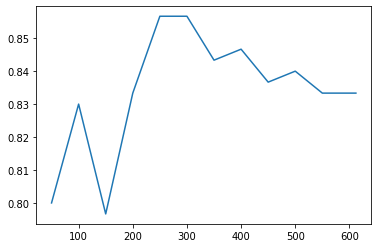

In [ ]:
plt.plot(numOfFeatures, accuracies)

In [ ]:
s = SVC(random_state=42)

X_train_part = X_train_tda[:, rf.feature_importances_.argsort()[-50:][::-1]]
s.fit(X_train_part, y_train)

X_test_num = tda_union.transform(X_test)[:, rf.feature_importances_.argsort()[-50:][::-1]]
s.score(X_test_num, y_test)

0.8

### 8. Grid Search with different numbers of features

#### 8.1 Random Forest

In [67]:
params_rf = []
scores_rf = []
accuracies_rf = []

rf_params = {
    "n_estimators": [500, 1000],
    'max_depth': [80, 90, 100],
    'max_features': [2, 3, 4],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300]
}

for num in numOfFeatures:
    print(num)
    bestFeatures = sortedFeatures[-num:][::-1]
    X_train_best = X_train_tda[:, bestFeatures]

    rf = RandomForestClassifier(random_state=42)

    rf_grid = GridSearchCV(
    estimator=rf, param_grid=rf_params, cv=3, n_jobs=-1, verbose=4
)

    rf_grid.fit(X_train_best, y_train)

    params_rf.append(rf_grid.best_params_)
    scores_rf.append(rf_grid.best_score_)

    X_test_num = X_test_tda[:, bestFeatures]
    accuracies_rf.append(rf_grid.best_estimator_.score(X_test_num, y_test))

print("FINISHED")

50
Fitting 3 folds for each of 243 candidates, totalling 729 fits
100
Fitting 3 folds for each of 243 candidates, totalling 729 fits
150
Fitting 3 folds for each of 243 candidates, totalling 729 fits
200
Fitting 3 folds for each of 243 candidates, totalling 729 fits
250
Fitting 3 folds for each of 243 candidates, totalling 729 fits
300
Fitting 3 folds for each of 243 candidates, totalling 729 fits
350
Fitting 3 folds for each of 243 candidates, totalling 729 fits
400
Fitting 3 folds for each of 243 candidates, totalling 729 fits
450
Fitting 3 folds for each of 243 candidates, totalling 729 fits
500
Fitting 3 folds for each of 243 candidates, totalling 729 fits
550
Fitting 3 folds for each of 243 candidates, totalling 729 fits
FINISHED


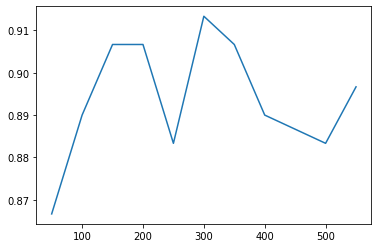

In [68]:
plt.plot(numOfFeatures, accuracies_rf)

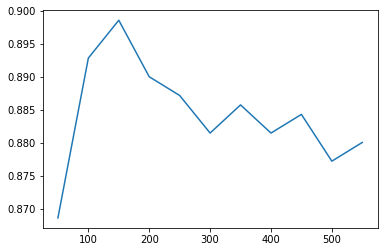

In [69]:
plt.plot(numOfFeatures, scores_rf)

#### 8.2 SVM

In [70]:
params_svm = []
scores_svm = []
accuracies_svm = []


svm_params = {
    'kernel' : ('linear', 'sigmoid', 'rbf', 'poly'),
    'C' : [10, 100],#[10 ** i for i in range(-2, 3)],
    'degree' : [3, 5, 7],
    'coef0' : [j**i for i in np.arange(-4,1,1) for j in np.arange(1.,4.,1.)],
    'gamma' : ('scale', 'auto'),
    'decision_function_shape': ('ovr', 'ovo')
}

for num in numOfFeatures:
    print(num)
    bestFeatures = sortedFeatures[-num:][::-1]
    X_train_best = X_train_tda[:, bestFeatures]

    svm = SVC(random_state=42)

    svm_grid = GridSearchCV(
        estimator=svm, param_grid=svm_params, cv=3, n_jobs=-1, verbose=4
    )

    svm_grid.fit(X_train_best, y_train)

    params_svm.append(svm_grid.best_params_)
    scores_svm.append(svm_grid.best_score_)

    X_test_num = X_test_tda[:, bestFeatures]
    accuracies_svm.append(svm_grid.best_estimator_.score(X_test_num, y_test))

print("FINISHED")

50
Fitting 3 folds for each of 1440 candidates, totalling 4320 fits
100
Fitting 3 folds for each of 1440 candidates, totalling 4320 fits
150
Fitting 3 folds for each of 1440 candidates, totalling 4320 fits
200
Fitting 3 folds for each of 1440 candidates, totalling 4320 fits
250
Fitting 3 folds for each of 1440 candidates, totalling 4320 fits
300
Fitting 3 folds for each of 1440 candidates, totalling 4320 fits
350
Fitting 3 folds for each of 1440 candidates, totalling 4320 fits
400
Fitting 3 folds for each of 1440 candidates, totalling 4320 fits
450
Fitting 3 folds for each of 1440 candidates, totalling 4320 fits
500
Fitting 3 folds for each of 1440 candidates, totalling 4320 fits
550
Fitting 3 folds for each of 1440 candidates, totalling 4320 fits
FINISHED


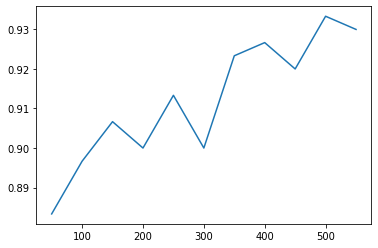

In [71]:
plt.plot(numOfFeatures, accuracies_svm)

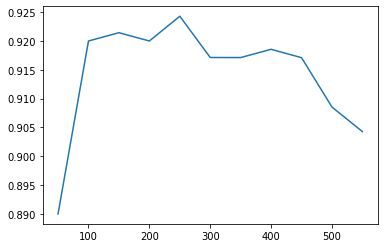

In [72]:
plt.plot(numOfFeatures, scores_svm)

#### 8.3 Logistic Regression

In [73]:
params_log = []
scores_log = []
accuracies_log = []


log_params = {
    "C" : np.logspace(-3,3,7), 
    "penalty" : ["l1","l2", "lasso"],
    "solver" : ["newton-cg", "lbfgs", "liblinear", "sag", "saga"]
}

for num in numOfFeatures:
    print(num)
    bestFeatures = sortedFeatures[-num:][::-1]
    X_train_best = X_train_tda[:, bestFeatures]

    log = LogisticRegression()

    log_grid = GridSearchCV(
        estimator=log, param_grid=log_params, cv=3, n_jobs=-1, verbose=4
    )

    log_grid.fit(X_train_best, y_train)

    params_log.append(log_grid.best_params_)
    scores_log.append(log_grid.best_score_)

    X_test_num = X_test_tda[:, bestFeatures]
    accuracies_log.append(log_grid.best_estimator_.score(X_test_num, y_test))

print("FINISHED")

50
Fitting 3 folds for each of 105 candidates, totalling 315 fits


/home/snopoff/miniconda3/envs/topology/lib/python3.9/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [       nan        nan 0.11429026        nan 0.11142903 0.12427399
 0.12427399 0.31573188 0.12427399 0.12427399        nan        nan
        nan        nan        nan        nan        nan 0.11856987
        nan 0.11572087 0.45428757 0.45428757 0.4214201  0.45571207
 0.45713657        nan        nan        nan        nan        nan
        nan        nan 0.5157062         nan 0.53712263 0.70290892
 0.70290892 0.71144981 0.70290892 0.70290892        nan        nan
        nan        nan        nan        nan        nan 0.83000746
        nan 0.82429723 0.82858907 0.82858907 0.82004818 0.82858907
 0.82858907        nan        nan        nan        nan        nan
        nan        nan 0.88714036        nan 0.83858504 0.85857697
 0.85857697 0.85002384 0.85001773 0.84144627        nan        nan
        nan        nan       

100
Fitting 3 folds for each of 105 candidates, totalling 315 fits


/home/snopoff/miniconda3/envs/topology/lib/python3.9/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [       nan        nan 0.11429026        nan 0.11142903 0.19994375
 0.19994375 0.43007104 0.19994375 0.19994375        nan        nan
        nan        nan        nan        nan        nan 0.22143355
        nan 0.11856987 0.69859262 0.69859262 0.61435751 0.69859262
 0.69859262        nan        nan        nan        nan        nan
        nan        nan 0.69571305        nan 0.69289461 0.82288495
 0.82288495 0.8386156  0.82288495 0.82288495        nan        nan
        nan        nan        nan        nan        nan 0.88570363
        nan 0.87144027 0.89001993 0.89001993 0.88143013 0.8857342
 0.8828852         nan        nan        nan        nan        nan
        nan        nan 0.91715271        nan 0.89002604 0.90858736
 0.90858736 0.89573016 0.89286893 0.89430566        nan        nan
        nan        nan        

150
Fitting 3 folds for each of 105 candidates, totalling 315 fits


/home/snopoff/miniconda3/envs/topology/lib/python3.9/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [       nan        nan 0.11429026        nan 0.11572087 0.299989
 0.299989   0.47148552 0.299989   0.299989          nan        nan
        nan        nan        nan        nan        nan 0.22143355
        nan 0.11856987 0.77146228 0.77146228 0.72006407 0.77146228
 0.77146228        nan        nan        nan        nan        nan
        nan        nan 0.72287639        nan 0.75856841 0.842883
 0.842883   0.84573811 0.842883   0.8443075         nan        nan
        nan        nan        nan        nan        nan 0.89570571
        nan 0.8871587  0.89288116 0.89288116 0.88714036 0.89288116
 0.89287505        nan        nan        nan        nan        nan
        nan        nan 0.92000171        nan 0.89573016 0.91570987
 0.91570987 0.90572613 0.90856902 0.89715467        nan        nan
        nan        nan        nan

200
Fitting 3 folds for each of 105 candidates, totalling 315 fits


/home/snopoff/miniconda3/envs/topology/lib/python3.9/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [       nan        nan 0.11429026        nan 0.10858614 0.35287896
 0.35287896 0.5586002  0.35287896 0.35430958        nan        nan
        nan        nan        nan        nan        nan 0.25285817
        nan 0.11856987 0.80429307 0.80429307 0.79144199 0.80429307
 0.80429307        nan        nan        nan        nan        nan
        nan        nan 0.73857036        nan 0.7857073  0.87718108
 0.87718108 0.86858516 0.87718108 0.87860558        nan        nan
        nan        nan        nan        nan        nan 0.8971241
        nan 0.89428121 0.90427717 0.90284656 0.89856694 0.90570779
 0.90143428        nan        nan        nan        nan        nan
        nan        nan 0.91141802        nan 0.89999144 0.91283029
 0.91426091 0.91284864 0.91141802 0.90142817        nan        nan
        nan        nan        

250
Fitting 3 folds for each of 105 candidates, totalling 315 fits


/home/snopoff/miniconda3/envs/topology/lib/python3.9/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [       nan        nan 0.11429026        nan 0.11429026 0.38576477
 0.38576477 0.58002274 0.38576477 0.38718927        nan        nan
        nan        nan        nan        nan        nan 0.11429026
        nan 0.11856987 0.80573591 0.80573591 0.79573383 0.80573591
 0.8057298         nan        nan        nan        nan        nan
        nan        nan 0.73713975        nan 0.78715014 0.88003619
 0.88003619 0.86716677 0.88003619 0.88146681        nan        nan
        nan        nan        nan        nan        nan 0.89999144
        nan 0.89571182 0.90856902 0.90856902 0.9028649  0.90856902
 0.9042894         nan        nan        nan        nan        nan
        nan        nan 0.92426299        nan 0.90856902 0.9242691
 0.91997726 0.9185711  0.90712618 0.90427717        nan        nan
        nan        nan        

300
Fitting 3 folds for each of 105 candidates, totalling 315 fits


/home/snopoff/miniconda3/envs/topology/lib/python3.9/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [       nan        nan 0.11429026        nan 0.10712495 0.46573249
 0.46573249 0.63002091 0.46573249 0.46715699        nan        nan
        nan        nan        nan        nan        nan 0.11429026
        nan 0.11572087 0.80003791 0.80003791 0.80146241 0.80003791
 0.79860729        nan        nan        nan        nan        nan
        nan        nan 0.75430102        nan 0.79716445 0.87431985
 0.87431985 0.870028   0.87574435 0.88003008        nan        nan
        nan        nan        nan        nan        nan 0.90140983
        nan 0.88858932 0.91143025 0.91143025 0.9071384  0.90715674
 0.89858528        nan        nan        nan        nan        nan
        nan        nan 0.9228446         nan 0.90716286 0.92285071
 0.92427522 0.91571598 0.92285683 0.90858736        nan        nan
        nan        nan       

350
Fitting 3 folds for each of 105 candidates, totalling 315 fits


/home/snopoff/miniconda3/envs/topology/lib/python3.9/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [       nan        nan 0.11429026        nan 0.10858614 0.50429185
 0.50429185 0.63716787 0.50429185 0.50429185        nan        nan
        nan        nan        nan        nan        nan 0.1028759
        nan 0.11856987 0.80291748 0.80291748 0.80148075 0.80148686
 0.80291136        nan        nan        nan        nan        nan
        nan        nan 0.77572356        nan 0.81427681 0.87716274
 0.87716274 0.86859127 0.87859335 0.87859335        nan        nan
        nan        nan        nan        nan        nan 0.9071384
        nan 0.88857709 0.91143025 0.91143025 0.90998741 0.9071384
 0.90287101        nan        nan        nan        nan        nan
        nan        nan 0.9199956         nan 0.90143428 0.92141399
 0.9214201  0.92570583 0.91570987 0.9042894         nan        nan
        nan        nan        na

400
Fitting 3 folds for each of 105 candidates, totalling 315 fits


/home/snopoff/miniconda3/envs/topology/lib/python3.9/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [       nan        nan 0.11429026        nan 0.11001675 0.54001443
 0.54001443 0.6400291  0.54001443 0.54144504        nan        nan
        nan        nan        nan        nan        nan 0.11429026
        nan 0.11856987 0.7986134  0.80004402 0.79861952 0.79861952
 0.79863174        nan        nan        nan        nan        nan
        nan        nan 0.75428267        nan 0.80855435 0.87999951
 0.87857501 0.87143416 0.88144847 0.88144847        nan        nan
        nan        nan        nan        nan        nan 0.9071384
        nan 0.89857305 0.91141802 0.90999352 0.91283641 0.90714452
 0.90715063        nan        nan        nan        nan        nan
        nan        nan 0.91143636        nan 0.90714452 0.91712825
 0.91998948 0.92143844 0.91141191 0.90857513        nan        nan
        nan        nan        

450
Fitting 3 folds for each of 105 candidates, totalling 315 fits


/home/snopoff/miniconda3/envs/topology/lib/python3.9/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [       nan        nan 0.11429026        nan 0.11429026 0.56574105
 0.56574105 0.64000465 0.56574105 0.57431251        nan        nan
        nan        nan        nan        nan        nan 0.13572503
        nan 0.11856987 0.80433586 0.80433586 0.81148283 0.80576648
 0.80862771        nan        nan        nan        nan        nan
        nan        nan 0.77141337        nan 0.80997885 0.88856486
 0.88428524 0.87287089 0.8857342  0.8843097         nan        nan
        nan        nan        nan        nan        nan 0.90142206
        nan 0.89143832 0.90712618 0.91284252 0.90426495 0.91141802
 0.89714855        nan        nan        nan        nan        nan
        nan        nan 0.90857513        nan 0.89714855 0.91712825
 0.92000171 0.91285475 0.9085629  0.90285267        nan        nan
        nan        nan       

500
Fitting 3 folds for each of 105 candidates, totalling 315 fits


/home/snopoff/miniconda3/envs/topology/lib/python3.9/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [       nan        nan 0.11429026        nan 0.11285964 0.61001064
 0.61001064 0.64002299 0.61001064 0.61716983        nan        nan
        nan        nan        nan        nan        nan 0.13572503
        nan 0.11856987 0.8086216  0.8100461  0.81718695 0.8143196
 0.81433183        nan        nan        nan        nan        nan
        nan        nan 0.76712764        nan 0.78285218 0.88570974
 0.88713425 0.87715051 0.88285463 0.88143013        nan        nan
        nan        nan        nan        nan        nan 0.90713229
        nan 0.88427913 0.90712006 0.90712618 0.90426495 0.90568945
 0.89569348        nan        nan        nan        nan        nan
        nan        nan 0.90998741        nan 0.8956996  0.91427314
 0.91855887 0.91569764 0.90568945 0.89997921        nan        nan
        nan        nan        

550
Fitting 3 folds for each of 105 candidates, totalling 315 fits


/home/snopoff/miniconda3/envs/topology/lib/python3.9/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [       nan        nan 0.11429026        nan 0.1085678  0.60859225
 0.61145348 0.65860264 0.61001675 0.62429845        nan        nan
        nan        nan        nan        nan        nan 0.13572503
        nan 0.11856987 0.8128951  0.8128951  0.81718083 0.80860937
 0.80432364        nan        nan        nan        nan        nan
        nan        nan 0.76569703        nan 0.78283384 0.88570363
 0.88570363 0.88286685 0.88429747 0.88143624        nan        nan
        nan        nan        nan        nan        nan 0.90141594
        nan 0.88569752 0.90855679 0.91426702 0.91426091 0.90427106
 0.89140164        nan        nan        nan        nan        nan
        nan        nan 0.91141802        nan 0.89283225 0.92140787
 0.91998337 0.92283849 0.90712618 0.89283225        nan        nan
        nan        nan       

FINISHED


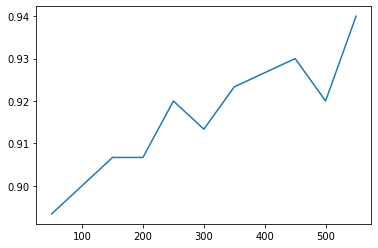

In [74]:
plt.plot(numOfFeatures, accuracies_log)

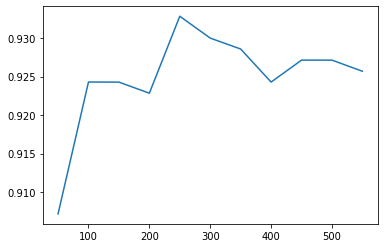

In [75]:
plt.plot(numOfFeatures, scores_log)

#### 8.4 CatBoost

In [98]:
params_cat = []
scores_cat = []
accuracies_cat = []

grid = {'learning_rate': [0.003, 0.03],
        'depth': [4, 6, 8],
        'l2_leaf_reg': [0.03, 0.1, 1]}

for num in numOfFeatures:
    print(num)
    bestFeatures = sortedFeatures[-num:][::-1]
    X_train_best = X_train_tda[:, bestFeatures]

    cat = CatBoostClassifier(iterations=250);

    grid_search_result = cat.grid_search(grid, 
                                       X=X_train_tda, 
                                       y=y_train, 
                                       plot=True)

    params_cat.append(grid_search_result.params)
    scores_cat.append(grid_search_result.cv_results['train-error-mean'])

    X_test_num = X_test_tda[:, bestFeatures]
    best = CatBoostClassifier(iterations=250, grid_search_result.params);
    best.fit(X_train_best, y_train);
    accuracies_cat.append(best.score(X_test_num, y_test))

print("FINISHED")

50


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 2.2920819	test: 2.2940782	best: 2.2940782 (0)	total: 513ms	remaining: 2m 7s
1:	learn: 2.2815160	test: 2.2852455	best: 2.2852455 (1)	total: 725ms	remaining: 1m 29s
2:	learn: 2.2731389	test: 2.2774098	best: 2.2774098 (2)	total: 942ms	remaining: 1m 17s
3:	learn: 2.2640713	test: 2.2699063	best: 2.2699063 (3)	total: 1.16s	remaining: 1m 11s
4:	learn: 2.2550766	test: 2.2616218	best: 2.2616218 (4)	total: 1.35s	remaining: 1m 6s
5:	learn: 2.2452952	test: 2.2526212	best: 2.2526212 (5)	total: 1.57s	remaining: 1m 3s
6:	learn: 2.2378188	test: 2.2453876	best: 2.2453876 (6)	total: 1.78s	remaining: 1m 1s
7:	learn: 2.2286248	test: 2.2372013	best: 2.2372013 (7)	total: 1.98s	remaining: 59.9s
8:	learn: 2.2181159	test: 2.2282455	best: 2.2282455 (8)	total: 2.15s	remaining: 57.7s
9:	learn: 2.2091755	test: 2.2199046	best: 2.2199046 (9)	total: 2.32s	remaining: 55.7s
10:	learn: 2.2001159	test: 2.2118564	best: 2.2118564 (10)	total: 2.5s	remaining: 54.2s
11:	learn: 2.1897728	test: 2.2034884	best: 2.20348

AttributeError: ignored

### 9 Adding new features


In [ ]:
direction_list = [[1, 0], [1, 1], [0, 1], [-1, 1], [-1, 0], [-1, -1], [0, -1], [1, -1]]

center_list = [
    [13, 6],
    [6, 13],
    [13, 13],
    [20, 13],
    [13, 20],
    [6, 6],
    [6, 20],
    [20, 6],
    [20, 20],
]

filtration_list = (
    [
        HeightFiltration(direction=np.array(direction), n_jobs=-1)
        for direction in direction_list
    ]
    + [RadialFiltration(center=np.array(center), n_jobs=-1) for center in center_list]
    #images.DilationFiltration
    #images.ErosionFiltration
    #images.SignedDistanceFiltration
    #images.DensityFiltration
)

diagram_steps = [
    [
        Binarizer(threshold=0.4, n_jobs=-1),
        filtration,
        CubicalPersistence(n_jobs=-1),
        Scaler(n_jobs=-1),
    ]
    for filtration in filtration_list
]

metric_list = [
    {"metric": "bottleneck", "metric_params": {}},
    {"metric": "wasserstein", "metric_params": {"p": 1}},
    {"metric": "wasserstein", "metric_params": {"p": 2}},
    {"metric": "landscape", "metric_params": {"p": 1, "n_layers": 1, "n_bins": 100}},
    {"metric": "landscape", "metric_params": {"p": 1, "n_layers": 2, "n_bins": 100}},
    {"metric": "landscape", "metric_params": {"p": 2, "n_layers": 1, "n_bins": 100}},
    {"metric": "landscape", "metric_params": {"p": 2, "n_layers": 2, "n_bins": 100}},
    {"metric": "betti", "metric_params": {"p": 1, "n_bins": 100}},
    {"metric": "betti", "metric_params": {"p": 2, "n_bins": 100}},
    {"metric": "heat", "metric_params": {"p": 1, "sigma": 1.6, "n_bins": 100}},
    {"metric": "heat", "metric_params": {"p": 1, "sigma": 3.2, "n_bins": 100}},
    {"metric": "heat", "metric_params": {"p": 2, "sigma": 1.6, "n_bins": 100}},
    {"metric": "heat", "metric_params": {"p": 2, "sigma": 3.2, "n_bins": 100}},
    #NEW FEATURES
    {"metric": "persistence_image", "metric_params": {"p": 1}}, 
    {"metric": "persistence_image", "metric_params": {"p": 2}},
    {"metric": "silhouette", "metric_params": {"p": 1}},
    {"metric": "silhouette", "metric_params": {"p": 2}}
]

feature_union = make_union(
    *[PersistenceEntropy(nan_fill_value=-1)] #add features
    + [Amplitude(**metric, n_jobs=-1) for metric in metric_list]
)

tda_union = make_union(
    *[make_pipeline(*diagram_step, feature_union) for diagram_step in diagram_steps],
    n_jobs=-1
)

set_config(display='diagram')

tda_union

FeatureUnion(n_jobs=-1,
             transformer_list=[('pipeline-1',
                                Pipeline(steps=[('binarizer',
                                                 Binarizer(n_jobs=-1,
                                                           threshold=0.4)),
                                                ('heightfiltration',
                                                 HeightFiltration(direction=array([1, 0]),
                                                                  n_jobs=-1)),
                                                ('cubicalpersistence',
                                                 CubicalPersistence(n_jobs=-1)),
                                                ('scaler', Scaler(n_jobs=-1)),
                                                ('featureunion',
                                                 FeatureUnion(transformer_list=[('persistenceentropy',
                                                                                 Persist...
                                                                                           n_jobs=-1)),
                                                                                ('amplitude-14',
                                                                                 Amplitude(metric='persistence_image',
                                                                                           metric_params={'p': 1},
                                                                                           n_jobs=-1)),
                                                                                ('amplitude-15',
                                                                                 Amplitude(metric='persistence_image',
                                                                                           metric_params={'p': 2},
                                                                                           n_jobs=-1)),
                                                                                ('amplitude-16',
                                                                                 Amplitude(metric='silhouette',
                                                                                           metric_params={'p': 1},
                                                                                           n_jobs=-1)),
                                                                                ('amplitude-17',
                                                                                 Amplitude(metric='silhouette',
                                                                                           metric_params={'p': 2},
                                                                                           n_jobs=-1))]))]))])

In [ ]:
X_train_tda = tda_union.fit_transform(X_train)
X_test_tda = tda_union.transform(X_test)
X_train_tda.shape

(700, 612)

### 10. Train models without topological features

In [ ]:
X_train_notop = X_train.reshape(X_train.shape[0],-1)
X_test_notop = X_test.reshape(X_test.shape[0],-1)

Random Forest Classifier

In [ ]:
rf = RandomForestClassifier()
rf.fit(X_train_notop, y_train)

rf.score(X_test_notop, y_test)

0.8933333333333333

Logistic Regression

In [ ]:
lr = LogisticRegression()
lr.fit(X_train_notop, y_train)

lr.score(X_test_notop, y_test)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


0.8833333333333333

SVC

In [ ]:
model_linear = SVC(kernel='linear')
model_linear.fit(X_train_notop, y_train)

model_linear.score(X_test_notop, y_test)

0.8733333333333333

LightGBM

In [ ]:
lgbm = LGBMClassifier()
lgbm.fit(X_train_notop, y_train)

lgbm.score(X_test_notop, y_test)

0.8633333333333333

CatBoost

In [ ]:
cat = CatBoostClassifier(task_type="GPU",
                           devices='0:1')
cat.fit(X_train_notop, y_train, verbose=False)

cat.score(X_test_notop, y_test)

0.89

XGBT

In [ ]:
xgb = XGBClassifier()
xgb.fit(X_train_notop, y_train)

xgb.score(X_test_notop, y_test)

0.8566666666666667

### 11 Grid Search for non-topological models

In [76]:
X_train_notop = X_train.reshape(X_train.shape[0],-1)
X_test_notop = X_test.reshape(X_test.shape[0],-1)

In [78]:
rf_feat_notop = RandomForestClassifier()
rf_feat_notop.fit(X_train_notop, y_train)
sortedFeatures = rf_feat_notop.feature_importances_.argsort()

numOfFeatures_notop = np.arange(50, len(sortedFeatures), 50)

In [80]:
params_notop_svm = []
scores_notop_svm = []
accuracies_notop_svm = []

svm_params = {
    'kernel' : ('linear', 'sigmoid', 'rbf', 'poly'),
    'C' : [10, 100],#[10 ** i for i in range(-2, 3)],
    'degree' : [3, 5, 7],
    'coef0' : [j**i for i in np.arange(-4,1,1) for j in np.arange(1.,4.,1.)],
    'gamma' : ('scale', 'auto'),
    'decision_function_shape': ('ovr', 'ovo')
}

for num in numOfFeatures_notop:
    print(num)
    bestFeatures = sortedFeatures[-num:][::-1]
    X_train_best = X_train_notop[:, bestFeatures]

    svm = SVC(random_state=42)

    svm_grid = GridSearchCV(
        estimator=svm, param_grid=svm_params, cv=3, n_jobs=-1, verbose=4
    )

    svm_grid.fit(X_train_best, y_train)

    params_notop_svm.append(svm_grid.best_params_)
    scores_notop_svm.append(svm_grid.best_score_)

    X_test_num = X_test_notop[:, bestFeatures]
    accuracies_notop_svm.append(svm_grid.best_estimator_.score(X_test_num, y_test))

50
Fitting 3 folds for each of 1440 candidates, totalling 4320 fits
100
Fitting 3 folds for each of 1440 candidates, totalling 4320 fits
150
Fitting 3 folds for each of 1440 candidates, totalling 4320 fits
200
Fitting 3 folds for each of 1440 candidates, totalling 4320 fits
250
Fitting 3 folds for each of 1440 candidates, totalling 4320 fits
300
Fitting 3 folds for each of 1440 candidates, totalling 4320 fits
350
Fitting 3 folds for each of 1440 candidates, totalling 4320 fits
400
Fitting 3 folds for each of 1440 candidates, totalling 4320 fits
450
Fitting 3 folds for each of 1440 candidates, totalling 4320 fits
500
Fitting 3 folds for each of 1440 candidates, totalling 4320 fits
550
Fitting 3 folds for each of 1440 candidates, totalling 4320 fits
600
Fitting 3 folds for each of 1440 candidates, totalling 4320 fits
650
Fitting 3 folds for each of 1440 candidates, totalling 4320 fits
700
Fitting 3 folds for each of 1440 candidates, totalling 4320 fits
750
Fitting 3 folds for each of 144

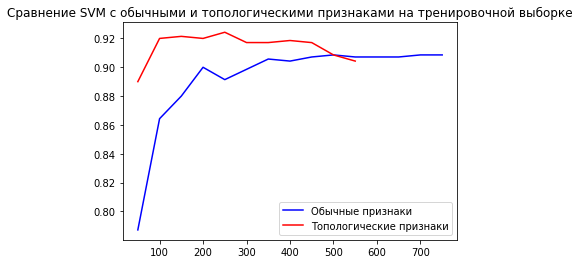

In [81]:
plt.plot(numOfFeatures_notop, scores_notop_svm, "-b", label="Обычные признаки")
plt.plot(numOfFeatures, scores_svm, "-r", label="Топологические признаки")
plt.legend(loc='best')
plt.title("Сравнение SVM с обычными и топологическими признаками на тренировочной выборке")
plt.savefig('images/svm_diff_features_train.png')
plt.show()

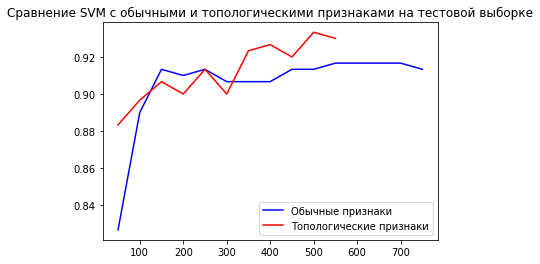

In [82]:
plt.plot(numOfFeatures_notop, accuracies_notop_svm, "-b", label="Обычные признаки")
plt.plot(numOfFeatures, accuracies_svm, "-r", label="Топологические признаки")
plt.legend(loc='best')
plt.title("Сравнение SVM с обычными и топологическими признаками на тестовой выборке")
plt.savefig('images/svm_diff_features_test.png')
plt.show()

In [83]:
params_notop_rf = []
scores_notop_rf = []
accuracies_notop_rf = []

rf_params = {
    "n_estimators": [500, 1000],
    'max_depth': [80, 90, 100],
    'max_features': [2, 3, 4],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300]
}

for num in numOfFeatures_notop:
    print(num)
    bestFeatures = sortedFeatures[-num:][::-1]
    X_train_best = X_train_notop[:, bestFeatures]

    rf = RandomForestClassifier(random_state=42)

    rf_grid = GridSearchCV(
    estimator=rf, param_grid=rf_params, cv=3, n_jobs=-1, verbose=4
)

    rf_grid.fit(X_train_best, y_train)

    params_notop_rf.append(rf_grid.best_params_)
    scores_notop_rf.append(rf_grid.best_score_)

    X_test_num = X_test_notop[:, bestFeatures]
    accuracies_notop_rf.append(rf_grid.best_estimator_.score(X_test_num, y_test))

print("FINISHED")

50
Fitting 3 folds for each of 243 candidates, totalling 729 fits
100
Fitting 3 folds for each of 243 candidates, totalling 729 fits
150
Fitting 3 folds for each of 243 candidates, totalling 729 fits
200
Fitting 3 folds for each of 243 candidates, totalling 729 fits
250
Fitting 3 folds for each of 243 candidates, totalling 729 fits
300
Fitting 3 folds for each of 243 candidates, totalling 729 fits
350
Fitting 3 folds for each of 243 candidates, totalling 729 fits
400
Fitting 3 folds for each of 243 candidates, totalling 729 fits
450
Fitting 3 folds for each of 243 candidates, totalling 729 fits
500
Fitting 3 folds for each of 243 candidates, totalling 729 fits
550
Fitting 3 folds for each of 243 candidates, totalling 729 fits
600
Fitting 3 folds for each of 243 candidates, totalling 729 fits
650
Fitting 3 folds for each of 243 candidates, totalling 729 fits
700
Fitting 3 folds for each of 243 candidates, totalling 729 fits
750
Fitting 3 folds for each of 243 candidates, totalling 729 f

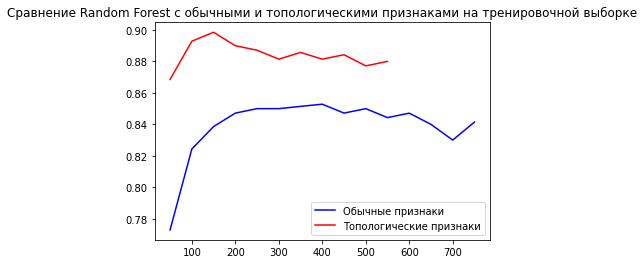

In [84]:
plt.plot(numOfFeatures_notop, scores_notop_rf, "-b", label="Обычные признаки")
plt.plot(numOfFeatures, scores_rf, "-r", label="Топологические признаки")
plt.legend(loc='best')
plt.title("Сравнение Random Forest с обычными и топологическими признаками на тренировочной выборке")
plt.savefig('images/rf_diff_features_train.png')
plt.show()

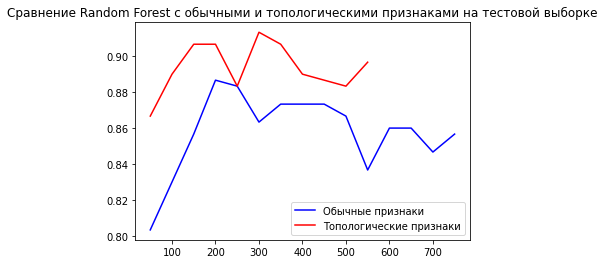

In [85]:
plt.plot(numOfFeatures_notop, accuracies_notop_rf, "-b", label="Обычные признаки")
plt.plot(numOfFeatures, accuracies_rf, "-r", label="Топологические признаки")
plt.legend(loc='best')
plt.title("Сравнение Random Forest с обычными и топологическими признаками на тестовой выборке")
plt.savefig('images/rf_diff_features_test.png')
plt.show()

In [86]:
params_notop_log = []
scores_notop_log = []
accuracies_notop_log = []


log_params = {
    "C" : np.logspace(-3,3,7), 
    "penalty" : ["l1","l2", "lasso"],
    "solver" : ["newton-cg", "lbfgs", "liblinear", "sag", "saga"]
}

for num in numOfFeatures_notop:
    print(num)
    bestFeatures = sortedFeatures[-num:][::-1]
    X_train_best = X_train_notop[:, bestFeatures]

    log = LogisticRegression()

    log_grid = GridSearchCV(
        estimator=log, param_grid=log_params, cv=3, n_jobs=-1, verbose=4
    )

    log_grid.fit(X_train_best, y_train)

    params_notop_log.append(log_grid.best_params_)
    scores_notop_log.append(log_grid.best_score_)

    X_test_num = X_test_notop[:, bestFeatures]
    accuracies_notop_log.append(log_grid.best_estimator_.score(X_test_num, y_test))

print("FINISHED")

50
Fitting 3 folds for each of 105 candidates, totalling 315 fits


/home/snopoff/miniconda3/envs/topology/lib/python3.9/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [       nan        nan 0.70139882        nan 0.71857232 0.66569458
 0.67426605 0.66853747 0.69713143 0.71000086        nan        nan
        nan        nan        nan        nan        nan 0.70857024
        nan 0.72141521 0.65139454 0.6613844  0.64425981 0.69712532
 0.71142536        nan        nan        nan        nan        nan
        nan        nan 0.65855373        nan 0.70856413 0.65712312
 0.6499517  0.63425773 0.68855386 0.70857024        nan        nan
        nan        nan        nan        nan        nan 0.65141289
        nan 0.70713963 0.66142719 0.64567208 0.63712507 0.69140897
 0.70857024        nan        nan        nan        nan        nan
        nan        nan 0.6285475         nan 0.70713963 0.65428634
 0.6456782  0.63998631 0.69140897 0.71000086        nan        nan
        nan        nan       

100
Fitting 3 folds for each of 105 candidates, totalling 315 fits


/home/snopoff/miniconda3/envs/topology/lib/python3.9/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [       nan        nan 0.73427852        nan 0.74431728 0.76427253
 0.76284802 0.70998863 0.76856437 0.77856645        nan        nan
        nan        nan        nan        nan        nan 0.74283164
        nan 0.78430114 0.76284191 0.7528704  0.69855593 0.7714256
 0.77571133        nan        nan        nan        nan        nan
        nan        nan 0.6856804         nan 0.77714195 0.76284191
 0.76000514 0.67997628 0.77712361 0.77428683        nan        nan
        nan        nan        nan        nan        nan 0.65995378
        nan 0.77428072 0.75426433 0.75856841 0.66140274 0.77571133
 0.77714195        nan        nan        nan        nan        nan
        nan        nan 0.66426397        nan 0.77713584 0.7471296
 0.76142964 0.64569042 0.77571133 0.77571745        nan        nan
        nan        nan        n

150
Fitting 3 folds for each of 105 candidates, totalling 315 fits


/home/snopoff/miniconda3/envs/topology/lib/python3.9/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [       nan        nan 0.75143367        nan 0.75146424 0.80431141
 0.79718279 0.76858271 0.79860729 0.80002568        nan        nan
        nan        nan        nan        nan        nan 0.77859702
        nan 0.79859506 0.80287468 0.79575217 0.75716225 0.79575217
 0.80146241        nan        nan        nan        nan        nan
        nan        nan 0.75432547        nan 0.80146241 0.79859506
 0.79290317 0.74430505 0.79718279 0.80288079        nan        nan
        nan        nan        nan        nan        nan 0.76430921
        nan 0.80431752 0.80003791 0.79004805 0.74286832 0.79860118
 0.79860118        nan        nan        nan        nan        nan
        nan        nan 0.77717252        nan 0.80002568 0.79289706
 0.78861133 0.74286221 0.80145629 0.80002568        nan        nan
        nan        nan       

200
Fitting 3 folds for each of 105 candidates, totalling 315 fits


/home/snopoff/miniconda3/envs/topology/lib/python3.9/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [       nan        nan 0.75716836        nan 0.77718474 0.81859922
 0.80576037 0.79714611 0.81145837 0.81431349        nan        nan
        nan        nan        nan        nan        nan 0.79143587
        nan 0.81145226 0.8157441  0.80576037 0.78857464 0.80574814
 0.80717264        nan        nan        nan        nan        nan
        nan        nan 0.7700011         nan 0.81288899 0.8143196
 0.80433586 0.78430114 0.8171686  0.81431349        nan        nan
        nan        nan        nan        nan        nan 0.78570118
        nan 0.81288899 0.81148894 0.80148075 0.77571133 0.81430737
 0.81288899        nan        nan        nan        nan        nan
        nan        nan 0.79142365        nan 0.8157441  0.80006847
 0.79862563 0.77714195 0.81003387 0.8157441         nan        nan
        nan        nan        

250
Fitting 3 folds for each of 105 candidates, totalling 315 fits


/home/snopoff/miniconda3/envs/topology/lib/python3.9/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [       nan        nan 0.75286429        nan 0.77289901 0.81859922
 0.80432975 0.79286037 0.81859922 0.8286013         nan        nan
        nan        nan        nan        nan        nan 0.79287872
        nan 0.81000942 0.81859922 0.79432767 0.79142976 0.81575022
 0.82288495        nan        nan        nan        nan        nan
        nan        nan 0.79142976        nan 0.81859922 0.81860533
 0.7971889  0.78714403 0.82004818 0.82717068        nan        nan
        nan        nan        nan        nan        nan 0.80572368
        nan 0.82004206 0.79575829 0.79575829 0.78714403 0.82146045
 0.82144822        nan        nan        nan        nan        nan
        nan        nan 0.79855838        nan 0.82002372 0.79004805
 0.79719502 0.78714403 0.81860533 0.82287884        nan        nan
        nan        nan       

300
Fitting 3 folds for each of 105 candidates, totalling 315 fits


/home/snopoff/miniconda3/envs/topology/lib/python3.9/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [       nan        nan 0.7542949         nan 0.76862551 0.82715234
 0.8143196  0.80998496 0.82001149 0.82715234        nan        nan
        nan        nan        nan        nan        nan 0.79715833
        nan 0.81430737 0.82858296 0.81003387 0.80711762 0.83286869
 0.82716457        nan        nan        nan        nan        nan
        nan        nan 0.79286649        nan 0.82286661 0.82572784
 0.80574814 0.80711762 0.82715846 0.83143807        nan        nan
        nan        nan        nan        nan        nan 0.80284411
        nan 0.82715234 0.80575425 0.80432364 0.80854823 0.82572173
 0.8314503         nan        nan        nan        nan        nan
        nan        nan 0.81999927        nan 0.83000135 0.80575425
 0.81003387 0.80854823 0.82573395 0.82715234        nan        nan
        nan        nan       

350
Fitting 3 folds for each of 105 candidates, totalling 315 fits


/home/snopoff/miniconda3/envs/topology/lib/python3.9/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [       nan        nan 0.75145201        nan 0.77148063 0.8342993
 0.8143196  0.80712984 0.83142585 0.83429319        nan        nan
        nan        nan        nan        nan        nan 0.7871746
        nan 0.81145226 0.83001969 0.8128951  0.80427473 0.83428708
 0.83285646        nan        nan        nan        nan        nan
        nan        nan 0.79001749        nan 0.82857684 0.8157441
 0.81003387 0.80713596 0.83285035 0.83428708        nan        nan
        nan        nan        nan        nan        nan 0.8114278
        nan 0.83428708 0.80574814 0.80860937 0.80284411 0.82857073
 0.83428708        nan        nan        nan        nan        nan
        nan        nan 0.80997885        nan 0.83714831 0.80289914
 0.80574814 0.8014135  0.83285035 0.83141973        nan        nan
        nan        nan        nan

400
Fitting 3 folds for each of 105 candidates, totalling 315 fits


/home/snopoff/miniconda3/envs/topology/lib/python3.9/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [       nan        nan 0.75145201        nan 0.77005001 0.83431153
 0.81145837 0.80713596 0.82857684 0.83714831        nan        nan
        nan        nan        nan        nan        nan 0.78859298
        nan 0.8157441  0.82859518 0.80860325 0.8100033  0.83143807
 0.83429319        nan        nan        nan        nan        nan
        nan        nan 0.80000734        nan 0.82858907 0.82289718
 0.80289302 0.81143392 0.83571769 0.83286869        nan        nan
        nan        nan        nan        nan        nan 0.80854823
        nan 0.82858296 0.80289302 0.80288691 0.8100033  0.82858296
 0.83286869        nan        nan        nan        nan        nan
        nan        nan 0.80856657        nan 0.83286869 0.80289302
 0.80716653 0.8100033  0.83572992 0.8342993         nan        nan
        nan        nan       

450
Fitting 3 folds for each of 105 candidates, totalling 315 fits


/home/snopoff/miniconda3/envs/topology/lib/python3.9/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [       nan        nan 0.75145201        nan 0.77148063 0.83858504
 0.81573799 0.81284619 0.83715442 0.8328748         nan        nan
        nan        nan        nan        nan        nan 0.79288483
        nan 0.8143196  0.83430542 0.81002164 0.81427069 0.82857684
 0.8328748         nan        nan        nan        nan        nan
        nan        nan 0.79715833        nan 0.83430542 0.8257523
 0.80717875 0.81428292 0.83429319 0.83715442        nan        nan
        nan        nan        nan        nan        nan 0.80571146
        nan 0.8342993  0.80860325 0.80717875 0.81428903 0.82860741
 0.83286869        nan        nan        nan        nan        nan
        nan        nan 0.81571965        nan 0.8342993  0.80717875
 0.80860325 0.80999719 0.83572992 0.8342993         nan        nan
        nan        nan        

500
Fitting 3 folds for each of 105 candidates, totalling 315 fits


/home/snopoff/miniconda3/envs/topology/lib/python3.9/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [       nan        nan 0.75145201        nan 0.76862551 0.83859115
 0.82002984 0.8128523  0.83144419 0.83572381        nan        nan
        nan        nan        nan        nan        nan 0.79716445
        nan 0.81575022 0.8342993  0.81573799 0.81427681 0.83286869
 0.83572381        nan        nan        nan        nan        nan
        nan        nan 0.79287872        nan 0.83143807 0.82860741
 0.81145226 0.81428292 0.83144419 0.83144419        nan        nan
        nan        nan        nan        nan        nan 0.81858088
        nan 0.83429319 0.80859714 0.80859714 0.81285842 0.83143807
 0.83572381        nan        nan        nan        nan        nan
        nan        nan 0.81856865        nan 0.83857892 0.80716653
 0.81144614 0.81428903 0.82716457 0.8328748         nan        nan
        nan        nan       

550
Fitting 3 folds for each of 105 candidates, totalling 315 fits


/home/snopoff/miniconda3/envs/topology/lib/python3.9/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [       nan        nan 0.75145201        nan 0.77148063 0.83859115
 0.82002372 0.81428292 0.83001357 0.83286869        nan        nan
        nan        nan        nan        nan        nan 0.79717056
        nan 0.8143196  0.8342993  0.81573799 0.81571353 0.8342993
 0.83572381        nan        nan        nan        nan        nan
        nan        nan 0.80145018        nan 0.8328748  0.8300258
 0.81430737 0.81570742 0.8342993  0.8342993         nan        nan
        nan        nan        nan        nan        nan 0.81427069
        nan 0.84000954 0.81860533 0.81288287 0.81428292 0.83573603
 0.83715442        nan        nan        nan        nan        nan
        nan        nan 0.81141558        nan 0.83429319 0.81002164
 0.81002164 0.81571353 0.83144419 0.83858504        nan        nan
        nan        nan        n

600
Fitting 3 folds for each of 105 candidates, totalling 315 fits


/home/snopoff/miniconda3/envs/topology/lib/python3.9/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [       nan        nan 0.75145201        nan 0.77148063 0.83859115
 0.82002372 0.81428292 0.82858907 0.83714831        nan        nan
        nan        nan        nan        nan        nan 0.79288483
        nan 0.8143196  0.8342993  0.81287676 0.81428292 0.83001969
 0.83143807        nan        nan        nan        nan        nan
        nan        nan 0.80001345        nan 0.83571769 0.8271768
 0.81002776 0.81570742 0.83001357 0.83571769        nan        nan
        nan        nan        nan        nan        nan 0.80714818
        nan 0.83858504 0.8157441  0.81288287 0.81571353 0.83429319
 0.83429319        nan        nan        nan        nan        nan
        nan        nan 0.82427888        nan 0.83573603 0.80859714
 0.81287676 0.81714415 0.83716053 0.83288092        nan        nan
        nan        nan        

650
Fitting 3 folds for each of 105 candidates, totalling 315 fits


/home/snopoff/miniconda3/envs/topology/lib/python3.9/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [       nan        nan 0.75145201        nan 0.77148063 0.83859115
 0.82144822 0.81571353 0.82859518 0.83144419        nan        nan
        nan        nan        nan        nan        nan 0.79573995
        nan 0.8171686  0.8342993  0.81430737 0.81571353 0.8342993
 0.8328748         nan        nan        nan        nan        nan
        nan        nan 0.79859506        nan 0.83001357 0.82718291
 0.81002776 0.81570742 0.83286258 0.83715442        nan        nan
        nan        nan        nan        nan        nan 0.80428695
        nan 0.83858504 0.81145226 0.81002164 0.81428292 0.82715234
 0.83715442        nan        nan        nan        nan        nan
        nan        nan 0.8114278         nan 0.83144419 0.81001553
 0.81144614 0.81428292 0.83430542 0.83428708        nan        nan
        nan        nan        

700
Fitting 3 folds for each of 105 candidates, totalling 315 fits


/home/snopoff/miniconda3/envs/topology/lib/python3.9/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [       nan        nan 0.75145201        nan 0.77148063 0.84144627
 0.82287884 0.81571353 0.83001357 0.83430542        nan        nan
        nan        nan        nan        nan        nan 0.79574606
        nan 0.8143196  0.8342993  0.8171686  0.81428292 0.83429319
 0.8342993         nan        nan        nan        nan        nan
        nan        nan 0.79715833        nan 0.83001357 0.83145642
 0.81002776 0.81428292 0.83288092 0.83429319        nan        nan
        nan        nan        nan        nan        nan 0.80999719
        nan 0.83715442 0.81145226 0.81144614 0.81714415 0.8342993
 0.83715442        nan        nan        nan        nan        nan
        nan        nan 0.81713192        nan 0.8328748  0.80858491
 0.81144614 0.81714415 0.8342993  0.83572381        nan        nan
        nan        nan        

750
Fitting 3 folds for each of 105 candidates, totalling 315 fits


/home/snopoff/miniconda3/envs/topology/lib/python3.9/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [       nan        nan 0.75145201        nan 0.77148063 0.84001565
 0.82573395 0.81714415 0.83143807 0.8342993         nan        nan
        nan        nan        nan        nan        nan 0.79716445
        nan 0.81717472 0.8342993  0.81288287 0.8114278  0.83715442
 0.83572381        nan        nan        nan        nan        nan
        nan        nan 0.79715833        nan 0.83001357 0.83146253
 0.81145837 0.81428292 0.83572381 0.8328748         nan        nan
        nan        nan        nan        nan        nan 0.8114278
        nan 0.83572381 0.81287676 0.81001553 0.81714415 0.83144419
 0.83572381        nan        nan        nan        nan        nan
        nan        nan 0.81571965        nan 0.83572381 0.81287676
 0.81572576 0.81714415 0.83144419 0.83572381        nan        nan
        nan        nan        

FINISHED


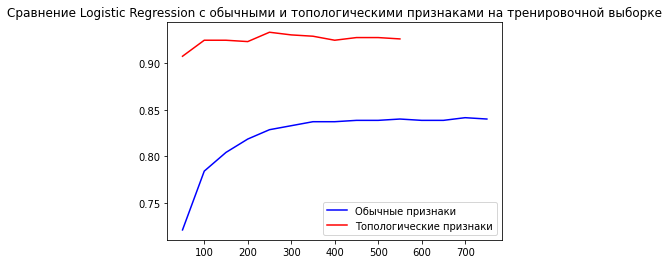

In [87]:
plt.plot(numOfFeatures_notop, scores_notop_log, "-b", label="Обычные признаки")
plt.plot(numOfFeatures, scores_log, "-r", label="Топологические признаки")
plt.legend(loc='best')
plt.title("Сравнение Logistic Regression с обычными и топологическими признаками на тренировочной выборке")
plt.savefig('images/log_diff_features_train.png')
plt.show()

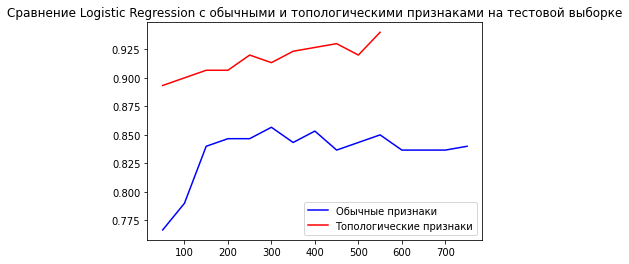

In [88]:
plt.plot(numOfFeatures_notop, accuracies_notop_log, "-b", label="Обычные признаки")
plt.plot(numOfFeatures, accuracies_log, "-r", label="Топологические признаки")
plt.legend(loc='best')
plt.title("Сравнение Logistic Regression с обычными и топологическими признаками на тестовой выборке")
plt.savefig('images/log_diff_features_test.png')
plt.show()

In [89]:
params_notop_cat = []
scores_notop_cat = []
accuracies_notop_cat = []

grid = {'learning_rate': [0.003, 0.03],
        'depth': [4, 6, 8],
        'l2_leaf_reg': [0.03, 0.1, 1]}

for num in numOfFeatures_notop:
    print(num)
    bestFeatures = sortedFeatures[-num:][::-1]
    X_train_best = X_train_notop[:, bestFeatures]

    cat = CatBoostClassifier(iterations=250);

    grid_search_result = cat.grid_search(grid, 
                                       X=X_train_best, 
                                       y=y_train, 
                                       plot=True)

    #grid_search_result.fit(X_train_best, y_train)

    params_notop_cat.append(grid_search_result.params)
    scores_notop_cat.append(grid_search_result.cv_results['train-error-mean'])

    X_test_num = X_test_notop[:, bestFeatures]
    best = CatBoostClassifier(iterations=250, grid_search_result.params);
    best.fit(X_train_best, y_train);
    accuracies_notop_cat.append(best.score(X_test_num, y_test))

print("FINISHED")

SyntaxError: positional argument follows keyword argument (<ipython-input-89-94100b4e223b>, line 27)

In [ ]:
plt.plot(numOfFeatures_notop, scores_notop_cat, "-b", label="Обычные признаки")
plt.plot(numOfFeatures, scores_cat, "-r", label="Топологические признаки")
plt.legend(loc='best')
plt.title("Сравнение CatBoost с обычными и топологическими признаками на тренировочной выборке")

In [ ]:
plt.plot(numOfFeatures_notop, accuracies_notop_cat, "-b", label="Обычные признаки")
plt.plot(numOfFeatures, accuracies_cat, "-r", label="Топологические признаки")
plt.legend(loc='best')
plt.title("Сравнение CatBoost с обычными и топологическими признаками на тестовой выборке")

In [ ]:
plt.plot(numOfFeatures, accuracies_log, "-b", label="Logistic Regression")
plt.plot(numOfFeatures, accuracies_svm, "-r", label="SVM")
plt.plot(numOfFeatures, accuracies_rf, "-g", label="Random Forest")
plt.legend(loc='best')
#plt.title("Сравнение CatBoost с обычными и топологическими признаками на тестовой выборке")
plt.savefig("images/models-topfeatures.png")
plt.show()

In [ ]:
best_svm_model = SVC(random_state=42, **params_svm[6])

In [48]:
pearsonr(X_train_tda, y_train)

UFuncTypeError: ufunc 'add' did not contain a loop with signature matching types (dtype('<U32'), dtype('<U32')) -> dtype('<U32')

In [53]:
import pandas as pd
data = pd.DataFrame(X_train_tda)
corr = data.corr()
columns = np.full((corr.shape[0],), True, dtype=bool)
for i in range(corr.shape[0]):
    for j in range(i+1, corr.shape[0]):
        if corr.iloc[i,j] >= 0.9:
            if columns[j]:
                columns[j] = False
selected_columns = data.columns[columns]
data = data[selected_columns]

In [59]:
data_test = pd.DataFrame(X_test_tda)
data_test = data_test[selected_columns]

In [60]:
data_test.shape

(300, 51)

In [55]:
best_svm_model.fit(data, y_train)

SVC(C=10, coef0=1.0, degree=5, gamma='auto', kernel='poly', random_state=42)

In [61]:
best_svm_model.score(data_test, y_test)

0.83

In [103]:
best_svm_model = SVC(random_state=42, **params_svm[6])
best_svm_model.fit(X_train_tda[:,sortedFeatures[-numOfFeatures[6]:][::-1]], y_train)

SVC(C=10, coef0=1.0, degree=5, gamma='auto', kernel='poly', random_state=42)

In [104]:
best_svm_model.score(X_test_tda[:,sortedFeatures[-numOfFeatures[6]:][::-1]], y_test)

0.89

In [105]:
y_hat = best_svm_model.predict(X_test_tda[:,sortedFeatures[-numOfFeatures[6]:][::-1]])

In [106]:
mismatches = np.where((y_hat == y_test) == False)[0]

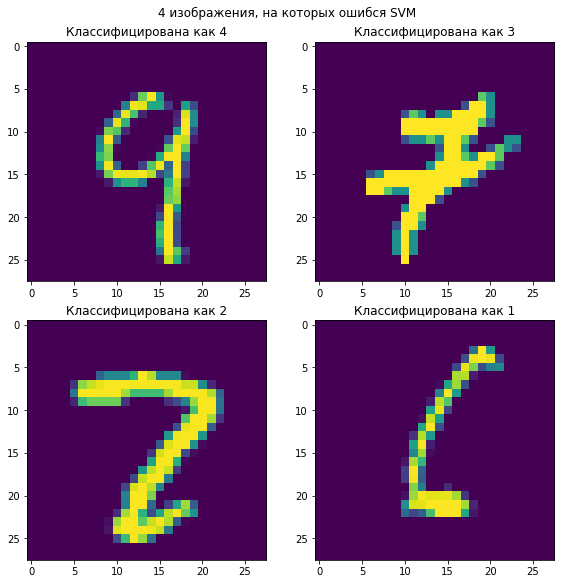

In [115]:
fig, axes = plt.subplots(2, 2, figsize = (8, 8), constrained_layout=True)
for i in range(4):
    ax = axes.flat[i]
    ind = mismatches[i+4]
    ax.imshow(X_test[ind])
    ax.title.set_text("Классифицирована как {}".format(y_hat[ind]))
fig.suptitle("4 изображения, на которых ошибся SVM")
plt.savefig("images/missclassified.png")
plt.show()
